## Data

For the following homework, we will be using a dataset under format JSON. The dataset consists of information regarding scientific conference informations, which have already been extracted from an in-house database:
-  **Authors** : information about author, separated by authorID and Author name
-  **Conference**: data containing infomation about a particular conference made of a conferenceID and the URL of conference in the site the data was collected from
-  **publication**: information about a publication made in a conference, that contains the publication ID, the URL of the publication and the title of the publication

A record in the JSON database is made of a list of authors, a conference ID, a conference Name, a conference URL, a  publication ID, a publication URL and the title the publication.

## Team
The team (Malick, Andreas and Biko) responsible for the analytics of the above dataset is  made of 3 data science students. The task to be performed on this data set are available on this following link. http://aris.me/contents/teaching/data-mining-ds-2017/homeworks/homework4.pdf




In [1]:
import networkx as nx
import json
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from heapq import *
import pickle

# PART 1: Data Cleaning 

Our first task in hand was the creation  of a network or a graph. One of our main goal is to understand the relationship between author and publication. Consequently we want to map out the different relationships between author and publication within a network so that we can analyse that network and derive some interesting information about it. By the end of this PART 1, we should have a graph that is made of as nodes Author ID.

The graph itelf is going to be a undirected graph that has weighted edges between authors that share at least one publication. The weight of those edges are going to be determined how similar two sets of publication are. We will be using the Jaccard similarity to deremined the weight.

    1.1 Data : 
The data is a single JSON file  (Reduce for testing and Full for analysis). The reduced dataset (size 1.44 MB) contains approximatively 3086 recods whereas the Full dataset (88.4 MB) contains records.
    
    2.1 Methods:
-  jaccard_sim(set1,set2): used the calculate the jaccard similarity between two sets of publication
-  load_json(name): Load a particular JSON file
-  save_json(name_file, data ): Save data in a variable 

# Definition of jaccard similarity

In [2]:
def jaccard_sim(set1,set2):
    set1=set(set1)
    set2=set(set2)
    return len(set1 & set2)/len( set1 | set2)

Define some functions to read and store data

In [3]:
def load_json(name):
    with open( name + '.json', 'r') as f:
        return json.load(f)

In [4]:
def save_json(name_file, data ):
    with open( name_file + '.json', 'w') as f:
        return json.dump(data, f,indent=3)

In [5]:
def load_obj_pickle(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
 

In [6]:
def save_obj_pickle(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [7]:
def save_graph(graph,file):
    
    return nx.write_gpickle(graph, file + 'gpickle')
    

In [8]:
def read_graph(file):   
    
    return nx.read_gpickle(file + 'gpickle')

Create a function that return a set that contain a set of conference

In [9]:
def create_conf_lst(diz):
    lst=set()
    for i in tqdm(range(len(diz))):
        lst.add(diz[i]["id_conference_int"])
    return lst

Read the Json file from local

In [10]:
data=load_json('reduced_dblp')

In [11]:
conf_lst=create_conf_lst(data)

100%|██████████████████████████████████| 3096/3096 [00:00<00:00, 773963.83it/s]


Create an empty graph

In [12]:
G=nx.Graph()

Define a function to create a dictionaty usefull to access information very fast

In [13]:
def dict_name(data):  

    DICT={}
  
    for i in tqdm(range(len(data))):

        for auth in range(len(data[i]['authors'])):

            if data[i]['authors'][auth]['author_id'] not in DICT.keys():

                DICT[data[i]['authors'][auth]['author_id']]={'author_name':data[i]['authors'][auth]['author'],
                                               'id_publication_int':[data[i]['id_publication_int']],
                                               'id_conference_int':[data[i]['id_conference_int']]}    

            else:
                DICT[data[i]['authors'][auth]['author_id']]['id_publication_int'].append(data[i]['id_publication_int']),
                DICT[data[i]['authors'][auth]['author_id']]['id_conference_int'].append(data[i]['id_conference_int'])    

    return DICT        

In [14]:
data_small=dict_name(data) 

100%|███████████████████████████████████| 3096/3096 [00:00<00:00, 88452.11it/s]


In [15]:
def graph_complete(data):
    G=nx.Graph()
    for k,v in tqdm(data.items()):
        G.add_node(k, **v)  #**v take the dict like attr
    return G


# Add nodes

Define a function to add nodes to graph.

Each node of the graph is an author ID

In [16]:
def graph_complete(data):
    G=nx.Graph()
    for k,v in tqdm(data.items()):
        G.add_node(k, **v)  #**v take the dict like attr
    return G

In [17]:
G=graph_complete(data_small)

100%|██████████████████████████████████| 7771/7771 [00:00<00:00, 267951.89it/s]


Define a function to create a dictionary which keys are the publication, and the id the list of conferences

In [18]:
def pub_id_f(data):
    
    dict_publication={}
    for i in tqdm(range(len(data))):
        dict_publication[data[i]["id_publication_int"]]=[]
        for j in range(len(data[i]["authors"])):
            dict_publication[data[i]["id_publication_int"]].append(data[i]["authors"][j]["author_id"]) 
        
                    
    return dict_publication

In [19]:
pub_id=pub_id_f(data)

100%|██████████████████████████████████| 3096/3096 [00:00<00:00, 182107.86it/s]


# Add edges using jaccard similarity as weight

In [20]:
def add_weighted_edges(pub_id,graph):

    for pub in tqdm(pub_id.keys()):
        
        for (i,v) in itertools.combinations(pub_id[pub], 2):
        
            graph.add_edge(i,v, weight= 1-jaccard_sim(graph.node[i]['id_publication_int'],
                                                      graph.node[v]['id_publication_int']))

    return graph

In [21]:
G=add_weighted_edges(pub_id,G)   

100%|███████████████████████████████████| 3096/3096 [00:00<00:00, 18992.74it/s]


In [22]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 7771\nNumber of edges: 16489\nAverage degree:   4.2437'

# POINT 2

## SUBPOINT 1

Given a conference in input, return the subgraph induced by the set of authors who published at the input conference at least once. Once you have the graph, compute some centralities measures (degree, closeness, betweeness) and plot them.

In [23]:
# We use function subgraph, that wants as parameter the list of nodes that are used in the subgraph

Ask to user a conference in input

In [234]:
control=False
while control==False:


    print("Insert conference id:")
    conf_input=int(input())
    if conf_input not in conf_lst:
        print("ERROR\nConference ID not found")
        print("Try another time")
        print("\n")
    else:
        control=True


Insert conference id:
4534342432
ERROR
Conference ID not found
Try another time


Insert conference id:
3045
ERROR
Conference ID not found
Try another time


Insert conference id:
16501


In [176]:
def conference_subgraph(data, conf_id):
    
    return G.subgraph([k for k in tqdm(data.keys()) if conf_id in data[k]['id_conference_int']])

In [177]:
K=conference_subgraph(data_small,conf_input)


100%|██████████| 7771/7771 [00:00<00:00, 954797.91it/s]

In [178]:
nx.info(K)

'Name: \nType: Graph\nNumber of nodes: 1012\nNumber of edges: 1802\nAverage degree:   3.5613'

Calculate degree centrality

In [179]:
degree = nx.degree_centrality(K)

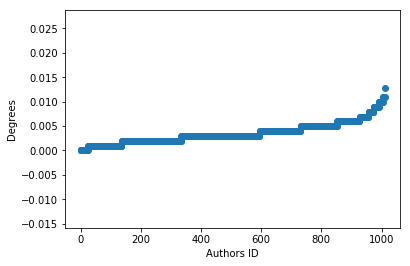

In [180]:
x= range(len(list(degree.values())))
y= sorted(list(degree.values()),reverse=False)
plt.scatter(x,y)
plt.xlabel("Authors ID")
plt.ylabel("Degrees")
plt.show()

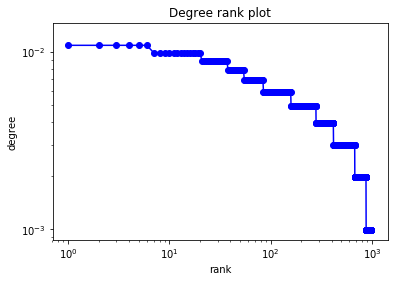

In [181]:
degree_sequence=sorted(degree.values(),reverse=True) # degree sequence

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

Closeness centrality

In [182]:
closeness=nx.closeness_centrality(K)

Betweeness centrality

In [183]:
betweeness = nx.betweenness_centrality(K,weight="weight")

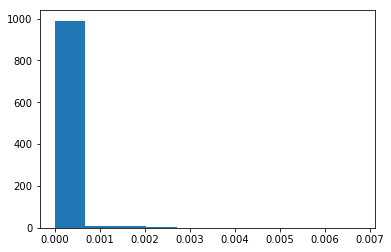

In [184]:
x= sorted(list(betweeness.keys()),reverse=True)
y= sorted(list(betweeness.values()),reverse=True)
plt.hist( y)
plt.show()

In [185]:
def centrality_scatter(dict1,dict2, ylab="",xlab="",title="",line=False):
 # Create figure and drawing axis
    fig = plt.figure(figsize=(7,7))
    ax1 = fig.add_subplot(111)
    # Create items and extract centralities
    items1 = sorted(dict1.items())
    items2 = sorted(dict2.items())
    xdata=[b for a,b in items1]
    ydata=[b for a,b in items2]

    # Add each actor to the plot by ID
    for p in range(len(items1)):
        ax1.text(x=xdata[p], y=ydata[p],s=str(items1[p][0]), color="b")

    if line:
        # use NumPy to calculate the best fit
        slope, yint = np.polyfit(xdata,ydata,1)
        xline = plt.xticks()[0]
        yline = list(map(lambda x: slope*x+yint,xline))
        ax1.plot(xline,yline,ls='--',color='r')
    # Set new x- and y-axis limits
    plt.xlim((0.0,max(xdata)+(.15*max(xdata))))
    plt.ylim((0.0,max(ydata)+(.15*max(ydata))))
    # Add labels and save
    ax1.set_title(title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab) 
    plt.show()

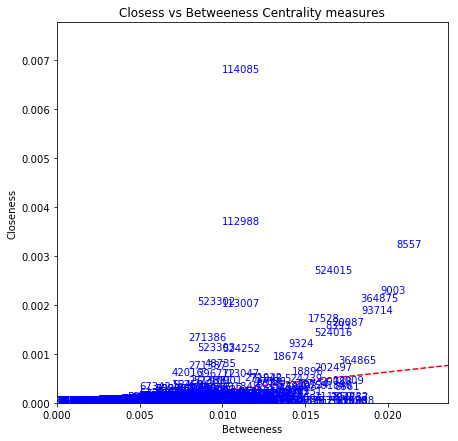

In [186]:
centrality_scatter(closeness,betweeness,"Closeness", "Betweeness", "Closess vs Betweeness Centrality measures", True)

# Point 2.2

In [187]:
def author_neighbors(graph,n):
    
    return list(nx.all_neighbors(graph,n))

In [188]:
def hop_distance(graph,node,d):
    
    if d==1:
        return author_neighbors(graph,node)+[node]
        
    else:
        ToT=set([node])
        N=set(author_neighbors(graph,node))
        for i in range(d-1):
        
            C=set()
            for n in N:
                L=author_neighbors(graph,n)
                A=set(L)
                C.update(A)
                ToT.update(A)
            N=C
        
        return list(ToT)

In [189]:
def draw_author_subgraph(graph,author_distance, node_input):
    a=graph.subgraph(author_distance)
    set_color=[ 'blue' if node==node_input else 'red' for node in a]
    return nx.draw_networkx(a, with_labels=False,node_color=set_color, 
                    node_size=2,
                   edge_color='grey', width = 0.1,font_weight='bold')

Obtain author id from input

In [198]:
control=False
while control==False:
    print("Type author id:")
    aut_input1=int(input())
    if aut_input1 in G.nodes():
        control=True
    else:
        print("Invalid input:\nTry another time\n")

Type author id:
256176


Obtain *d* distance from input

In [199]:
print("Insert an integer:")
dist=int(input())

Insert an integer:
3


In [200]:
author_distance_scratch= hop_distance(G,aut_input1,dist)  

In [201]:
author_distance_scratch

[101380,
 317456,
 356372,
 226324,
 263195,
 695329,
 523302,
 523303,
 444456,
 444462,
 444463,
 523311,
 172088,
 560185,
 163903,
 220232,
 560214,
 122973,
 85091,
 9317,
 20582,
 18537,
 317546,
 18538,
 695406,
 16500,
 17525,
 17526,
 17528,
 79993,
 101498,
 113793,
 114820,
 114821,
 465032,
 356527,
 256176,
 256177,
 524464,
 524465,
 20698,
 17629,
 622814,
 226529,
 272611,
 255205,
 490729,
 16618,
 16617,
 18669,
 18672,
 18674,
 20722,
 20724,
 20723,
 364795,
 270600,
 270601,
 364811,
 15628,
 101661,
 287,
 290079,
 290081,
 256291,
 364836,
 16680,
 255275,
 490807,
 20793,
 569661,
 364863,
 881985,
 256339,
 364884,
 271706,
 364895,
 255328,
 255327,
 272748,
 490865,
 115063,
 695685,
 695686,
 695687,
 364934,
 456091,
 220576,
 226733,
 449967,
 396734,
 150975,
 20929,
 17864,
 143817,
 104916,
 18910,
 365027,
 396772,
 273893,
 365043,
 365046,
 20994,
 311816,
 15881,
 290313,
 39449,
 365084,
 256548,
 15924,
 518711,
 365141,
 20087,
 20088,
 365188,
 

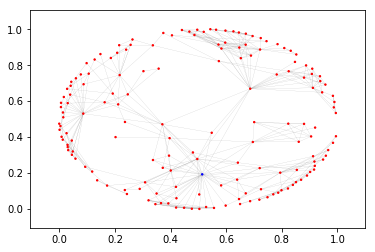

In [202]:
draw_author_subgraph(G,author_distance_scratch,aut_input1) 
plt.show()

# POINT 3.1

For part 3, we were tasked with computing some generalized version of the Erdős number, which measures the "collaborative distance" in authoring academic papers between that person and Hungarian mathematician Paul Erdős. In our case, instead of using Mr Paul Erdos we will be using Aris.

The data we will be using in this case is going to be made off authors as nodes and authors that share at least one publication as weighed edges. 

The goal of this task is to find the shortest path between an input author and Aris, using the weights previously calculated as a measure of distance. In order to find the shortest path, we will be using the Dijkstra shortest path algorithm. We wrote that algorithm in different ways, unfortunately, we have always stumbled with performance issue. For example, we first used the general implementation of the Dijkstra algorithm as described in Wikipedia. We ended up having a working code that took around 17 minutes to find the shortest path between two nodes. Refactoring the same algorithm allowed us to dial it down to 5 min which was in our case still way too long.

After some discussion, we wanted to see is there was a way we could combine the the Dijkstra Algorithm with the different costs saved in a heap since we used to recompute the various cost in our previous implementation. After doing some reseach, we took as reference the approach used by Alexey Kalachev which did exactly want we wanted it to do.

So for this task we needed Aris id which is 256176

In [203]:
aris=256176

Then we needed to have a list of edges which is basically saved in a tuple that will containt a starting node, its connected node along with the weights. We will be using that list as a reverence for our Dijksta algorithm.

In [204]:
lst_tot=[]
#list of edges to be used in our Dijksta algorithm
for xx in G.nodes(): 
    for yy in G[xx]:

        lst=(xx,yy,G[xx][yy]["weight"])
        lst_tot.append(lst)
        

One we have a list of edges we can run ou algorighm. It will take as an input the list of edges, a starting node and target node. 
   
1.  We first declare a defaut dictiorary g so that each node in g has a list made of tuples that link to its connected edge along with the weight of that connection
2.  we declare a list containing the unvisited node and a set containing the visited node
3.  while there are still some unvisited nodes. The unvisited nodes will be a tuple containing the cost , the node itsel and the path is took. If the new unvisited node is not in visited (seen), we then add the that node and its path to the visited set. Now is that particular node is equal to the target node, we return the cost and terminate the algorithm (because this is what we are looking for)
4.  if it's not equal to the target vertex, we will take the the vertices is point to, update the code by adding it to the previous, along with the path and pushing it to the heap of unvisited nodes q. Then we will restart at step 3.
5. If all the nodes are visited and there are no nurerical cost outputed, the program will return 'inf' which means that there are no path beween the input node and the target node


In [205]:
def dijkstra_heap(edges, start, end):
    # default dictionary containing nodes with list of its connected edges and weigh
    g = defaultdict(list)
    for node1,node2,weight in edges:
        g[node1].append((weight,node2)) #saved in tuples

    q = [(0,start,())] #unvisited nodes
    seen=set() #visited nodes
    
    while q: #while there are still some visited nodes
        (cost,v1,path) = heappop(q) #take the smallest one
        if v1 not in seen: #if the node has not been visited yet
            seen.add(v1) #add node to the visited one
            path = (v1, path) #update the path with this node
            if v1 == end: return (cost) #if it is equal to target node return the cost and terminate the algorithm

            for c, v2 in g.get(v1, ()): #else get the node its conneted to 
                if v2 not in seen: #if connected nodes not in the visited ones
                    heappush(q, (cost+c, v2, path)) #add the unvisited edges to the heap and restart the loop until target node found

    return float("inf") #if the path doesnt exit return infinity

Now take an author in input

In [206]:
control=False
while control==False:
    print("Type author id:")
    aut_input=int(input())
    if aut_input in G.nodes():
        control=True
    else:
        print("Invalid input:\nTry another time\n")

Type author id:
225741


In [207]:
dijkstra_heap(lst_tot,aris,aut_input)

5.988396471949104

# Point 3.2

Write a Python software that takes in input a subset of nodes (cardinality smaller than 21) and returns, for each node of the graph, its GroupNumber

In [208]:
subset=[]
controll=False
while controll==False:
    sub_set_n=int(input("Insert the number of nodes that you want to insert in the subset:"))
    if sub_set_n>21:
        print("Cardinality has to be smaller that 21!")
    else:
        controll=True
for i in range(sub_set_n):
    cont=False
    while cont==False:
        print("Insert element number",i+1)
        element=int(input())
        if element not in G.nodes():
            print("This node is not in the graph!\n Insert another time the",i+1,"node")
        elif element in subset:
            print("This element has already been selected")
        else:
            subset.append(element)
            cont=True

Insert the number of nodes that you want to insert in the subset:3
Insert element number 1
225741
Insert element number 2
575693
Insert element number 3
19384


In [209]:
subset

[225741, 575693, 19384]

In [232]:
groupNumbers = {}
cc=0
for e in subset:
    groupNumbers[e] = []

for node in tqdm((G)):
   
    currentLow = 1000000
    gNumber = 0
    check1=True
    
    for k in subset:
        


        # If there are no possible path, we don't evaluate the dijkstra_heap
        if nx.has_path(G,node,k)==False:
            continue

        else:
            result = dijkstra_heap(lst_tot,k,node)

            if result == 'inf':
                continue

            # Set a control variable to break the loop if the distance is 0 --> there will be no other smaller distance
            if result == 0:
                currentLow = result
                gNumber= k
                break

            if result < currentLow:
                currentLow = result
                gNumber= k

    if gNumber == 0:
        continue
    
    else:
        groupNumbers[gNumber].append(node)


100%|██████████| 7771/7771 [01:19<00:00, 98.03it/s]


In [233]:
groupNumbers

{19384: [803306, 19384],
 225741: [20405,
  20407,
  255405,
  9308,
  175195,
  17178,
  255537,
  21462,
  255688,
  255689,
  255690,
  255691,
  15924,
  8985,
  8987,
  8988,
  19285,
  19460,
  8612,
  256176,
  256177,
  255328,
  114483,
  202882,
  256135,
  256482,
  20392,
  8857,
  8819,
  271611,
  16249,
  19355,
  16145,
  18433,
  223848,
  271612,
  175489,
  271613,
  17368,
  271614,
  17611,
  16521,
  168357,
  271615,
  271616,
  17509,
  17973,
  17974,
  16665,
  16837,
  16867,
  271623,
  17824,
  15938,
  17423,
  15815,
  17426,
  16053,
  15816,
  16309,
  15983,
  15982,
  17853,
  16752,
  17184,
  17829,
  15850,
  16486,
  18268,
  101615,
  15939,
  17770,
  15871,
  15872,
  18686,
  271767,
  16222,
  264678,
  17002,
  15858,
  16438,
  16884,
  16830,
  271768,
  17206,
  271797,
  271798,
  271799,
  271800,
  271801,
  271802,
  21484,
  16390,
  271839,
  16392,
  21665,
  17292,
  15866,
  15884,
  15883,
  15986,
  15885,
  109393,
  271875,
 

In [231]:
for i in subset:
    print(dijkstra_heap(lst_tot,i,66957))
    print(i)

6.164285714285715
225741
inf
575693
inf
19384


In [24]:
G[18254]

{16231: {'weight': 0.0},
 16232: {'weight': 0.75},
 18276: {'weight': 0.5},
 85454: {'weight': 0.0},
 271930: {'weight': 0.0},
 271931: {'weight': 0.6666666666666667}}